In [1]:
pip install OWSLib pillow

   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ------------------- -------------------- 1.8/3.8 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 3.8/3.8 MB 9.9 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   -------------------- ------------------- 1/2 [OWSLib]
   -------------------- ------------------- 1/2 [OWSLib]
   -------------------- ------------------- 1/2 [OWSLib]
   -------------------- ------------------- 1/2 [OWSLib]
   -------------------- ------------------- 1/2 [OWSLib]
   -------------------- ------------------- 1/2 [OWSLib]
   -------------------- ------------------- 1/2 [OWSLib]
   ---------------------------------------- 2/2 [OWSLib]

Note: you may need to restart the kernel to use updated packages.


In [1]:
from owslib.wms import WebMapService
wms = WebMapService('https://ows.emodnet-bathymetry.eu/wms', version='1.3.0')
print(list(wms.contents.keys()))


['coastlines', 'emodnet:contours', 'emodnet:download_tiles', 'emodnet:hr_bathymetry_area', 'emodnet:mean', 'emodnet:mean_2016', 'emodnet:mean_2018', 'emodnet:mean_2020', 'emodnet:mean_2022', 'emodnet:mean_atlas_land', 'emodnet:mean_multicolour', 'emodnet:mean_rainbowcolour', 'emodnet:quality_index', 'world:sea_names', 'emodnet:source_references', 'gebco:undersea_features']


In [2]:
from owslib.wfs import WebFeatureService
import geopandas as gpd

# Parámetros
lat, lon = 40.35, 0.40
buffer_deg = 0.2

# Orden correcto de bbox para WFS: lon_min, lat_min, lon_max, lat_max
minx, miny = lon - buffer_deg, lat - buffer_deg
maxx, maxy = lon + buffer_deg, lat + buffer_deg

# Conexión al WFS
wfs = WebFeatureService(
    url='https://ows.emodnet-bathymetry.eu/wfs',
    version='2.0.0'
)

# Petición sin filtros y pidiendo todas las propiedades
response = wfs.getfeature(
    typename='emodnet:contours',
    bbox=(minx, miny, maxx, maxy),
    outputFormat='application/json',
    # si hiciera falta forzar propiedades:
    # propertyname=['elevation']
)

# Cargamos en GeoPandas
gdf = gpd.read_file(response)

# Inspecciona columnas y primeras filas
print("Columnas disponibles:", gdf.columns.tolist())
print(gdf.head())


Columnas disponibles: ['id', 'elevation', 'geometry']
               id  elevation  \
0  contours.23776         50   

                                            geometry  
0  LINESTRING (0.8006 40.4937, 0.8006 40.4936, 0....  


In [3]:
from owslib.wfs import WebFeatureService
import geopandas as gpd
from io import BytesIO

# Misma ventana que antes
lat, lon = 40.35, 0.40
delta = 0.1
min_lon, min_lat = lon - delta, lat - delta
max_lon, max_lat = lon + delta, lat + delta

# Conecta al WFS EMODnet
wfs = WebFeatureService('https://ows.emodnet-bathymetry.eu/wfs', version='2.0.0')

# Descarga la capa de contornos como GeoJSON
resp = wfs.getfeature(
    typename='emodnet:contours',             # <- parámetro singular
    bbox=(min_lon, min_lat, max_lon, max_lat),
    outputFormat='application/json'
)

# Cárgalo en GeoPandas
gdf = gpd.read_file(BytesIO(resp.read()))
gdf.head()  # GeoDataFrame con las líneas de contorno


,id,elevation,geometry
0,contours.23776,50,"LINESTRING (0.8006 40.4937, 0.8006 40.4936, 0...."


In [4]:
import folium

# Parámetros del mapa
lat, lon, zoom = 40.35, 0.40, 10
m = folium.Map(location=[lat, lon], zoom_start=zoom, tiles='OpenStreetMap')

# 1) Overlay: símbolos náuticos
folium.TileLayer(
    tiles='https://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
    attr='© OpenSeaMap contributors',
    name='Seamarks',
    overlay=True,
    control=True
).add_to(m)

# 2) Overlay: contornos de profundidad (WMS EMODnet)
folium.raster_layers.WmsTileLayer(
    url='https://ows.emodnet-bathymetry.eu/wms?',
    layers='emodnet:contours',
    fmt='image/png',
    transparent=True,
    version='1.3.0',
    attr='© EMODnet Bathymetry',            # <- usar attr, no attribution
    name='Contornos (EMODnet)',
    overlay=True,
    control=True,
    opacity=1.0
).add_to(m)

# 3) Control de capas
folium.LayerControl().add_to(m)

# 4) Mostrar
m


In [2]:
import folium

# 1) Parámetros de tu área de interés
lat, lon, zoom = 40.35, 0.40, 12

# 2) Mapa base: OpenStreetMap
m = folium.Map(
    location=[lat, lon],
    zoom_start=zoom,
    tiles='OpenStreetMap',
    attr='© OpenStreetMap contributors'
)

# 4) Capa “Mean depth in multi colour (no land)”
folium.raster_layers.WmsTileLayer(
    url='https://ows.emodnet-bathymetry.eu/wms?',
    name='Mean depth (multicolour)',
    layers='emodnet:mean_multicolour',# emodnet:mean_multicolour
    fmt='image/png',
    transparent=True,
    version='1.3.0',
    attr='© EMODnet Bathymetry',
    overlay=True,
    control=True,
    opacity=0.7
).add_to(m)

# 5) Capa OSM adicional (si quieres cambiar a otra variante OSM)
#    Ejemplo: Stamen Toner Lite como base alternativa
folium.TileLayer(
    tiles='https://stamen-tiles.a.ssl.fastly.net/toner-lite/{z}/{x}/{y}.png',
    attr='Map tiles by Stamen Design, under CC BY 3.0. Data © OpenStreetMap',
    name='OSM Toner Lite',
    overlay=False,
    control=True
).add_to(m)

# 6) Control de capas
folium.LayerControl().add_to(m)

# 7) Mostrar el mapa
m


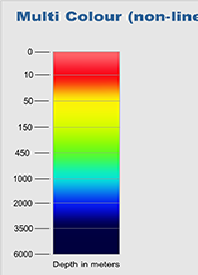

In [1]:
import requests
from PIL import Image
from io import BytesIO

base = "https://ows.emodnet-bathymetry.eu/wms"
params = {
    "SERVICE":        "WMS",
    "VERSION":        "1.3.0",
    "REQUEST":        "GetLegendGraphic",
    "LAYER":          "emodnet:mean_rainbowcolour", # emodnet:mean_multicolour
    "FORMAT":         "image/png",
    "WIDTH":          250,      # ajusta para visibilidad
    "HEIGHT":         300,     # ajusta para visibilidad
    "LEGEND_OPTIONS": "fontName:Arial;fontSize:12;forceLabels:on"
}
resp = requests.get(base, params=params)
resp.raise_for_status()
img = Image.open(BytesIO(resp.content))
display(img)   # en notebook verás la barra de degradado completa
